In [78]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install seaborn

In [1]:
from turtle import shape
import nibabel as nib
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import pandas as pd
import imblearn
import re
import seaborn as sns

# Setting paths for different folders
FLAIR_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar'
T1_Lacunes_Incorrect = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space.tar'
T1_Lacunes_Correct = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space_JiyangCorrected20210920'
T1_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1_withLacunes_35.tar'
T1_Soft_Tissue = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1softTiss_withLacunes_35.tar'
T1_Soft_Tissue_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35.tar'
T1_Soft_Tissue_Binary_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35_binary.tar'


In [2]:
def read_data():
    #Read all data into list
    T1_scan_data = []
    for file in os.listdir(T1_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            T1_scan_data.append(Data_list)

    #Read all FLAIR data into list
    FLAIR_scan_data = []
    for file in os.listdir(FLAIR_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(FLAIR_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            FLAIR_scan_data.append(Data_list)

    #Lacune Exists
    Lacune_indicator_data = []
    for file in os.listdir(T1_Lacunes_Correct):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Lacunes_Correct, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Lacune_indicator_data.append(Data_list)

    Soft_tiss_data = []
    for file in os.listdir(T1_Soft_Tissue):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Soft_tiss_data.append(Data_list)

    return T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data
T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data = read_data()
print("complete")

complete


In [3]:
def sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_lacune = []
    X_test_3D_lacune = []
    Y_train_3D_lacune = []
    Y_test_3D_lacune = []
    Y_train_segment_3D_lacune = []
    Y_test_segment_3D_lacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]

            #Sample lacunes
            for x in range(0, data.shape[0]):
                for y in range(0, data.shape[1]):
                    for z in range(0, data.shape[2]):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10] 

                            if brain_image <= 24:
                                if (Lacune_data[x,y,z] == 1):
                                    X_train_3D_lacune.append(brain_values)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_segment_3D_lacune.append(lacune_binary)

                            else:
                                if (Lacune_data[x,y,z] == 1):
                                    X_test_3D_lacune.append(brain_values)
                                    Y_test_3D_lacune.append(1)
                                    Y_test_segment_3D_lacune.append(lacune_binary)
                            
            brain_image += 1
            print(brain_image)
    return X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune
X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune = sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [4]:
def non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_nlacune = []
    X_test_3D_nlacune = []
    Y_train_3D_nlacune = []
    Y_test_3D_nlacune = []
    Y_train_segment_3D_nlacune = []
    Y_test_segment_3D_nlacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            
            #Sample lacunes
            #Reduce step size to 5??
            for x in range(0, data.shape[0], 15):
                for y in range(0, data.shape[1], 15):
                    for z in range(0, data.shape[2], 15):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10]

                            if brain_image <= 24:
                                # No lacune exists in the 3D patch, add to train set
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_train_3D_nlacune.append(brain_values)
                                    Y_train_3D_nlacune.append(0)
                                    Y_train_segment_3D_nlacune.append(lacune_binary)
                                    
                            else:
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_test_3D_nlacune.append(brain_values)
                                    Y_test_3D_nlacune.append(0)
                                    Y_test_segment_3D_nlacune.append(lacune_binary)
            brain_image += 1
            print(brain_image)

    return X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune
X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune = non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [5]:
X_train = np.concatenate((X_train_3D_lacune, X_train_3D_nlacune), axis=0)
X_test = np.concatenate((X_test_3D_lacune, X_test_3D_nlacune), axis=0)
Y_train = np.concatenate((Y_train_3D_lacune, Y_train_3D_nlacune), axis=0)
Y_test = np.concatenate((Y_test_3D_lacune, Y_test_3D_nlacune), axis=0)
Y_train_segment = np.concatenate((Y_train_segment_3D_lacune, Y_train_segment_3D_nlacune), axis=0)
Y_test_segment = np.concatenate((Y_test_segment_3D_lacune, Y_test_segment_3D_nlacune), axis=0)
print(len(X_train_3D_nlacune))
print(len(X_train_3D_lacune))
print("done")

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


27368
2351
done


In [219]:
#Features
filterSize =(5,5)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)

min_T1 = []
med_T1 = []
mid_T1 = []
mid_small_ratio_T1 = []
mid_med_ratio_T1 = []
mid_large_ratio_T1 = []
mid_small_ratio_T1_inc = []
mid_med_ratio_T1_inc = []
mid_large_ratio_T1_inc = []
mean_T1 = []
max_T1 = []
min_FLAIR = []
med_FLAIR = []
mid_FLAIR = []
mid_small_ratio_FLAIR = []
mid_med_ratio_FLAIR = []
mid_large_ratio_FLAIR = []
mid_small_ratio_FLAIR_inc = []
mid_med_ratio_FLAIR_inc = []
mid_large_ratio_FLAIR_inc = []
mean_FLAIR = []
max_FLAIR = []
density_diff = []
sum_soft_tiss_binary = []
sum_percent_soft_tiss = []
min_st = []
med_st = []
mid_st = []
mid_small_ratio_st = []
mid_med_ratio_st = []
mid_large_ratio_st = []
mid_small_ratio_st_inc = []
mid_med_ratio_st_inc = []
mid_large_ratio_st_inc = []
mean_st = []
max_st = []
min_th_T1 = []
med_th_T1 = []
mid_th_T1 = []
mid_small_ratio_th_T1 = []
mid_med_ratio_th_T1 = []
mid_large_ratio_th_T1 = []
mid_small_ratio_th_T1_inc = []
mid_med_ratio_th_T1_inc = []
mid_large_ratio_th_T1_inc = []
mean_th_T1 = []
max_th_T1 = []
min_th_st = []
med_th_st = []
mid_th_st = []
mid_small_ratio_th_st = []
mid_med_ratio_th_st = []
mid_large_ratio_th_st = []
mid_small_ratio_th_st_inc = []
mid_med_ratio_th_st_inc = []
mid_large_ratio_th_st_inc = []
mean_th_st = []
max_th_st = []
x = []
y = []
z = []

for index in range(len(X_train)):
    tophat_img_T1 = cv2.morphologyEx(X_train[index][4], cv2.MORPH_BLACKHAT,kernel)
    tophat_img_st = cv2.morphologyEx(X_train[index][7], cv2.MORPH_BLACKHAT,kernel)
    min_T1.append(np.min(X_train[index][4]))
    med_T1.append(np.median(X_train[index][4]))
    mid_T1.append(X_train[index][4][10,10,10])
    mid_small_ratio_T1.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_T1_inc.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_train[index][4]))
    max_T1.append(np.max(X_train[index][4]))
    min_FLAIR.append(np.min(X_train[index][5]))
    med_FLAIR.append(np.median(X_train[index][5]))
    mid_FLAIR.append(X_train[index][5][10,10,10])
    mid_small_ratio_FLAIR.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_FLAIR_inc.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    max_FLAIR.append(np.max(X_train[index][5]))
    density_diff.append(X_train[index][5][10,10,10] - X_train[index][4][10,10,10])
    sum_soft_tiss_binary.append(sum(sum(sum(X_train[index][6]))))
    sum_percent_soft_tiss.append(sum(sum(sum(X_train[index][7]))))
    min_st.append(np.min(X_train[index][6]))
    med_st.append(np.median(X_train[index][6]))
    mid_st.append(X_train[index][6][10,10,10])
    mid_small_ratio_st.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_st_inc.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st.append(np.mean(X_train[index][6]))
    max_st.append(np.max(X_train[index][6]))
    min_th_T1.append(np.min(tophat_img_T1))
    med_th_T1.append(np.median(tophat_img_T1))
    mid_th_T1.append(tophat_img_T1[10,10,10])
    mid_small_ratio_th_T1.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_th_T1_inc.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1.append(np.mean(tophat_img_T1))
    max_th_T1.append(np.max(tophat_img_T1))
    min_th_st.append(np.min(tophat_img_st))
    med_th_st.append(np.median(tophat_img_st))
    mid_th_st.append(tophat_img_st[10,10,10])
    mid_small_ratio_th_st.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_th_st_inc.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_th_st.append(np.mean(tophat_img_st))
    max_th_st.append(np.max(tophat_img_st))
    x.append(X_train[index][1])
    y.append(X_train[index][2])
    z.append(X_train[index][3])
    
    #edges = canny(tophat_img)


print(len(min_T1))
print(len(med_T1))
print(len(mid_T1))
print(len(mid_small_ratio_T1))
print(len(mid_med_ratio_T1))
print(len(mid_large_ratio_T1))
print(len(mid_small_ratio_T1_inc))
print(len(mid_med_ratio_T1_inc))
print(len(mid_large_ratio_T1_inc))
print(len(mean_T1))
print(len(max_T1))
print(len(min_FLAIR))
print(len(med_FLAIR))
print(len(mid_FLAIR))
print(len(mid_small_ratio_FLAIR))
print(len(mid_med_ratio_FLAIR))
print(len(mid_large_ratio_FLAIR))
print(len(mid_small_ratio_FLAIR_inc))
print(len(mid_med_ratio_FLAIR_inc))
print(len(mid_large_ratio_FLAIR_inc))
print(len(mean_FLAIR))
print(len(max_FLAIR))
print(len(sum_soft_tiss_binary))
print(len(sum_percent_soft_tiss))
print(len(min_st))
print(len(med_st))
print(len(mid_st))
print(len(mid_small_ratio_st))
print(len(mid_med_ratio_st))
print(len(mid_large_ratio_st))
print(len(mid_small_ratio_st_inc))
print(len(mid_med_ratio_st_inc))
print(len(mid_large_ratio_st_inc))
print(len(mean_st))
print(len(max_st))
print(len(x))
print(len(y))
print(len(z))

C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:120: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_th_st.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:123: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_th_st_inc.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:84: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_FLAIR.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:85: RuntimeWarning: invalid value encountered in double_

C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:75: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_T1.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:78: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_T1_inc.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))))/2744))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  mid_small_ratio_T1.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/797585187.py:109: RuntimeWarning: divide by zero encounte

29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719
29719


In [217]:
#Features
min_T1_test = []
med_T1_test = []
mid_T1_test = []
mid_small_ratio_T1_test = []
mid_med_ratio_T1_test = []
mid_large_ratio_T1_test = []
mid_small_ratio_T1_inc_test = []
mid_med_ratio_T1_inc_test = []
mid_large_ratio_T1_inc_test = []
mean_T1_test = []
max_T1_test = []
min_FLAIR_test = []
med_FLAIR_test = []
mid_FLAIR_test = []
mid_small_ratio_FLAIR_test = []
mid_med_ratio_FLAIR_test = []
mid_large_ratio_FLAIR_test = []
mid_small_ratio_FLAIR_inc_test = []
mid_med_ratio_FLAIR_inc_test = []
mid_large_ratio_FLAIR_inc_test = []
mean_FLAIR_test = []
max_FLAIR_test = []
density_diff_test = []
sum_soft_tiss_binary_test = []
sum_percent_soft_tiss_test = []
min_st_test = []
med_st_test = []
mid_st_test = []
mid_small_ratio_st_test = []
mid_med_ratio_st_test = []
mid_large_ratio_st_test = []
mid_small_ratio_st_inc_test = []
mid_med_ratio_st_inc_test = []
mid_large_ratio_st_inc_test = []
mean_st_test = []
max_st_test = []
min_th_T1_test = []
med_th_T1_test = []
mid_th_T1_test = []
mid_small_ratio_th_T1_test = []
mid_med_ratio_th_T1_test = []
mid_large_ratio_th_T1_test = []
mid_small_ratio_th_T1_inc_test = []
mid_med_ratio_th_T1_inc_test = []
mid_large_ratio_th_T1_inc_test = []
mean_th_T1_test = []
max_th_T1_test = []
min_th_st_test = []
med_th_st_test = []
mid_th_st_test = []
mid_small_ratio_th_st_test = []
mid_med_ratio_th_st_test = []
mid_large_ratio_th_st_test = []
mid_small_ratio_th_st_inc_test = []
mid_med_ratio_th_st_inc_test = []
mid_large_ratio_th_st_inc_test = []
mean_th_st_test = []
max_th_st_test = []
x_test = []
y_test = []
z_test = []

for index in range(len(X_test)):
    tophat_img_T1 = cv2.morphologyEx(X_test[index][4], cv2.MORPH_BLACKHAT,kernel)
    tophat_img_st = cv2.morphologyEx(X_test[index][7], cv2.MORPH_BLACKHAT,kernel)
    min_T1_test.append(np.min(X_test[index][4]))
    med_T1_test.append(np.median(X_test[index][4]))
    mid_T1_test.append(X_test[index][4][10,10,10])
    mid_small_ratio_T1_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_T1_inc_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_train[index][4]))
    mean_T1_test.append(np.mean(X_test[index][4]))
    max_T1_test.append(np.max(X_test[index][4]))
    min_FLAIR_test.append(np.min(X_test[index][5]))
    med_FLAIR_test.append(np.median(X_test[index][5]))
    mid_FLAIR_test.append(X_train[index][5][10,10,10])
    mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    mean_FLAIR_test.append(np.mean(X_test[index][5]))
    max_FLAIR_test.append(np.max(X_test[index][5]))
    density_diff_test.append(X_test[index][5][10,10,10]/X_test[index][4][10,10,10])
    sum_soft_tiss_binary_test.append(sum(sum(sum(X_test[index][6]))))
    sum_percent_soft_tiss_test.append(sum(sum(sum(X_test[index][7]))))
    min_st_test.append(np.min(X_train[index][6]))
    med_st_test.append(np.median(X_train[index][6]))
    mid_st_test.append(X_train[index][6][10,10,10])
    mid_small_ratio_st_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_st_inc_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st_test.append(np.mean(X_test[index][6]))
    max_st_test.append(np.max(X_test[index][6]))
    min_th_T1_test.append(np.min(tophat_img_T1))
    med_th_T1_test.append(np.median(tophat_img_T1))
    mid_th_T1_test.append(tophat_img_T1[10,10,10])
    mid_small_ratio_th_T1_test.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1_test.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1_test.append(np.mean(tophat_img_T1))
    max_th_T1_test.append(np.max(tophat_img_T1))
    min_th_st_test.append(np.min(tophat_img_st))
    med_th_st_test.append(np.median(tophat_img_st))
    mid_th_st_test.append(tophat_img_st[10,10,10])
    mid_small_ratio_th_st_test.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st_test.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st_test.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_small_ratio_th_st_inc_test.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc_test.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc_test.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_th_st_test.append(np.mean(tophat_img_st))
    max_th_st_test.append(np.max(tophat_img_st))
    x_test.append(X_test[index][1])
    y_test.append(X_test[index][2])
    z_test.append(X_test[index][3])

C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:82: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][5][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:83: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:84: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_

C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:71: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_T1_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:74: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_T1_inc_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/512))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:110: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_th_T1_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_29340/2762236851.py:113: RuntimeWarning: invalid value encounter

In [220]:
dataset = pd.DataFrame({'min_T1': min_T1, 'med_T1': med_T1, 'mid_T1': mid_T1, 'mid_small_ratio_T1': mid_small_ratio_T1, 'mid_med_ratio_T1': mid_med_ratio_T1, 'mid_large_ratio_T1': mid_large_ratio_T1, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc, 'mean_T1': mean_T1, 'max_T1': max_T1, 'min_FLAIR': min_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mean_FLAIR': mean_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc,  'med_FLAIR': med_FLAIR, 'max_FLAIR': max_FLAIR, 'density_diff': density_diff, 'sum_soft_tiss_binary': sum_soft_tiss_binary, 'sum_percent_soft_tiss': sum_percent_soft_tiss, 'min_st': min_st, 'med_st': med_st, 'mid_st': mid_st, 'mid_small_ratio_st': mid_small_ratio_st, 'mid_med_ratio_st': mid_med_ratio_st, 'mid_large_ratio_st': mid_large_ratio_st, 'mid_small_ratio_st_inc': mid_small_ratio_st_inc, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc, 'mean_st': mean_st, 'max_st': max_st, 'min_th_T1': min_th_T1, 'med_th_T1': med_th_T1, 'mid_th_T1': mid_th_T1, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc, 'mean_th_T1': mean_th_T1, 'max_th_T1': max_th_T1, 'min_th_st': min_th_st, 'med_th_st': med_th_st, 'mid_th_st': mid_th_st, 'mid_small_ratio_th_st': mid_small_ratio_th_st, 'mid_med_ratio_th_st': mid_med_ratio_th_st, 'mid_large_ratio_th_st': mid_large_ratio_th_st, 'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc, 'mean_th_st': mean_th_st, 'max_th_st': max_th_st, 'x': x, 'y': y, 'z': z})

In [221]:
names = dataset.columns

In [222]:
dataset=np.nan_to_num(dataset, nan=-1, posinf=99, neginf=-99)

In [223]:
dataset_test = pd.DataFrame({'min_T1': min_T1_test, 'med_T1': med_T1_test, 'mid_T1': mid_T1_test, 'mid_small_ratio_T1': mid_small_ratio_T1_test, 'mid_med_ratio_T1': mid_med_ratio_T1_test, 'mid_large_ratio_T1': mid_large_ratio_T1_test, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc_test, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc_test, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc_test, 'mean_T1': mean_T1_test, 'max_T1': max_T1_test, 'min_FLAIR': min_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mean_FLAIR': mean_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR_test, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR_test, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR_test, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc_test, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc_test, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc_test,  'med_FLAIR': med_FLAIR_test, 'max_FLAIR': max_FLAIR_test, 'density_diff': density_diff_test, 'sum_soft_tiss_binary': sum_soft_tiss_binary_test, 'sum_percent_soft_tiss': sum_percent_soft_tiss_test, 'min_st': min_st_test, 'med_st': med_st_test, 'mid_st': mid_st_test, 'mid_small_ratio_st': mid_small_ratio_st_test, 'mid_med_ratio_st': mid_med_ratio_st_test, 'mid_large_ratio_st': mid_large_ratio_st_test, 'mid_small_ratio_st_inc': mid_small_ratio_st_inc_test, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc_test, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc_test, 'mean_st': mean_st_test, 'max_st': max_st_test, 'min_th_T1': min_th_T1_test, 'med_th_T1': med_th_T1_test, 'mid_th_T1': mid_th_T1_test, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1_test, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1_test, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1_test, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc_test, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc_test, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc_test, 'mean_th_T1': mean_th_T1_test, 'max_th_T1': max_th_T1_test, 'min_th_st': min_th_st_test, 'med_th_st': med_th_st_test, 'mid_th_st': mid_th_st_test, 'mid_small_ratio_th_st': mid_small_ratio_th_st_test, 'mid_med_ratio_th_st': mid_med_ratio_th_st_test, 'mid_large_ratio_th_st': mid_large_ratio_th_st_test, 'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc_test, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc_test, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc_test, 'mean_th_st': mean_th_st_test, 'max_th_st': max_th_st_test, 'x': x_test, 'y': y_test, 'z': z_test})

In [224]:
dataset_test=np.nan_to_num(dataset_test, nan=-1, posinf=99, neginf=-99)

In [323]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1000, min_samples_leaf = 40, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
clf.fit(dataset, Y_train)
prediction = clf.predict(dataset_test)

In [324]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction)

array([[10930,    13],
       [  694,   306]], dtype=int64)

In [320]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10943
           1       0.96      0.34      0.50      1000

    accuracy                           0.94     11943
   macro avg       0.95      0.67      0.74     11943
weighted avg       0.94      0.94      0.93     11943



In [321]:
print(clf.oob_score_)

0.9886268044012249


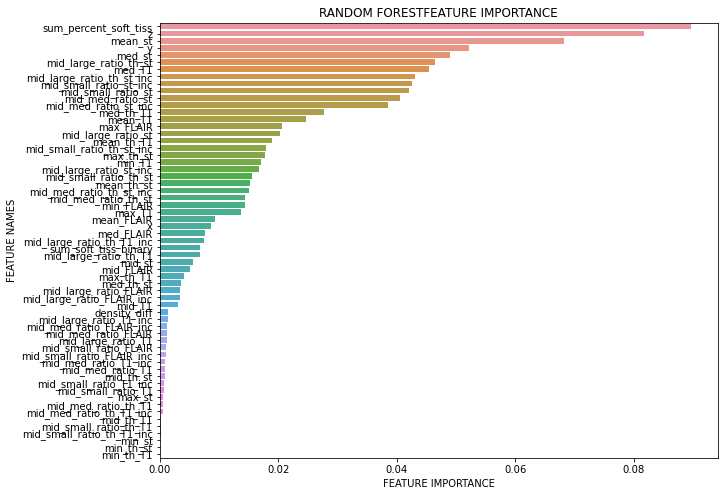

In [322]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(clf.feature_importances_,names,'RANDOM FOREST')

In [166]:
pip install PyDIP

  Created wheel for PyDIP: filename=pydip-0.1.8-py3-none-any.whl size=19843 sha256=8eff4e2c6d4459a4365a19a12477ce1c157394e73558d30521906c8c257fc4d5
  Stored in directory: c:\users\ellen\appdata\local\pip\cache\wheels\92\1b\91\8be2230d56da4a9cfcecf5956baa52c24a5be92aa85c030ed4
Successfully built PyDIP
Note: you may need to restart the kernel to use updated packages.


In [7]:
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import PyDIP as dip
# global thresholding
kernel = (3,3)
img = X_train[105][5][:, 10, :]
#opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
#im_bin = (img < 0.6)
#th1 = cv2.threshold(img,0.25,0.5,cv2.THRESH_BINARY)
lines = dip.Tophat(img, 10, polarity='black')
lines = dip.Tophat(img, 10, polarity='black')
dip.SetBorder(lines, [0], [2])
lines = dip.PathOpening(lines, length=100, polarity='opening', mode={'robust'})
lines = dip.Threshold(lines, method='otsu')[0]
contours = cv2.findContours(img, 150, 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


edges = canny(im_bin)
plt.imshow(im_bin, cmap="gray", origin="lower")

ModuleNotFoundError: No module named 'PyDIP'

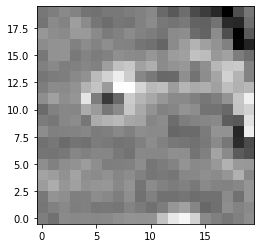

In [17]:
filterSize =(12,12)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
# Reading the image named 'input.jpg'
input_image = X_train[5][5][:, 10, :]
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, cv2.MORPH_TOPHAT,kernel)
edges = canny(tophat_img)
plt.imshow(tophat_img, cmap="gray", origin="lower")
plt.show()

In [210]:
tophat_img

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [244]:
### Hessian Matrix
import numpy as np

def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

hessian_slice = hessian(X_train[5][5][:, 10, :])
hessian_slice[0][0][0]

array([ 0.0108434 ,  0.00240962,  0.00963855,  0.01204818,  0.00963855,
        0.04096386,  0.03493974,  0.03614458,  0.02650604,  0.01445784,
        0.05301201,  0.06385544,  0.04939759,  0.04337347,  0.0590362 ,
        0.04819275,  0.01927711, -0.02891566, -0.02650602,  0.01566264])

In [246]:
pip install itk

In [248]:
import argparse

import itk
from distutils.version import StrictVersion as VS

if VS(itk.Version.GetITKVersion()) < VS("5.0.0"):
    print("ITK 5.0.0 or newer is required.")
    sys.exit(1)

parser = argparse.ArgumentParser(description="Segment blood vessels.")
parser.add_argument("input_image")
parser.add_argument("output_image")
parser.add_argument("--sigma", type=float, default=1.0)
parser.add_argument("--alpha1", type=float, default=0.5)
parser.add_argument("--alpha2", type=float, default=2.0)
args = parser.parse_args()

input_image = itk.imread(X_train[5][5][:, 10, :], itk.ctype("float"))

hessian_image = itk.hessian_recursive_gaussian_image_filter(
    input_image, sigma=args.sigma
)

vesselness_filter = itk.Hessian3DToVesselnessMeasureImageFilter[
    itk.ctype("float")
].New()
vesselness_filter.SetInput(hessian_image)
vesselness_filter.SetAlpha1(args.alpha1)
vesselness_filter.SetAlpha2(args.alpha2)

itk.imwrite(vesselness_filter, args.output_image)

usage: ipykernel_launcher.py [-h] [--sigma SIGMA] [--alpha1 ALPHA1] [--alpha2 ALPHA2] input_image output_image
ipykernel_launcher.py: error: the following arguments are required: output_image


SystemExit: 2

In [249]:
# Read image
im = X_train[5][5][:, 10, :]
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector()
# Detect blobs.
keypoints = detector.detect(im)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)


error: Unknown C++ exception from OpenCV code

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.feature import blob_dog, blob_log, blob_doh

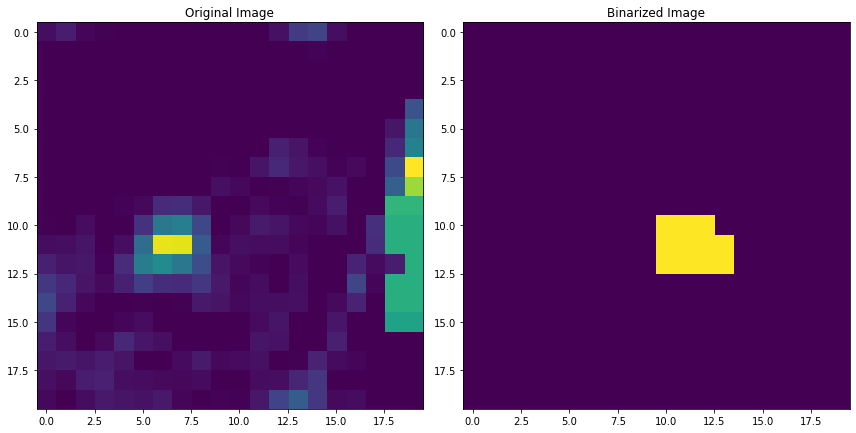

In [287]:
leaves = tophat_img
leaves_mask = Y_train_segment[5][:, 10, :]

fig, axis = plt.subplots(1,2, figsize=(12,6))
axis[0].imshow(leaves);
axis[0].set_title('Original Image')
axis[1].imshow(leaves_mask)
axis[1].set_title('Binarized Image')
plt.tight_layout()

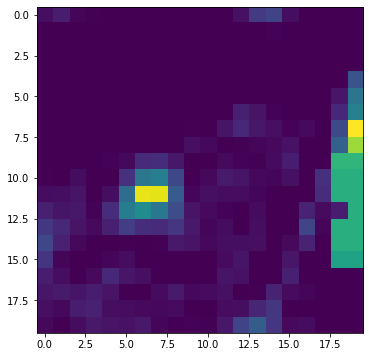

In [288]:
blobs = blob_dog(leaves_mask, min_sigma=5)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(leaves)
for blob in blobs:
    y, x, area = blob
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), 
                 color='r', fill=False))

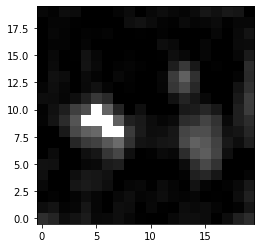

In [299]:
filterSize =(5,5)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
# Reading the image named 'input.jpg'
input_image = X_train[200][7][:, 10, :]
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, cv2.MORPH_BLACKHAT,kernel)
edges = canny(tophat_img)
plt.imshow(tophat_img, cmap="gray", origin="lower")
plt.show()

In [297]:
sample_g = tophat_img

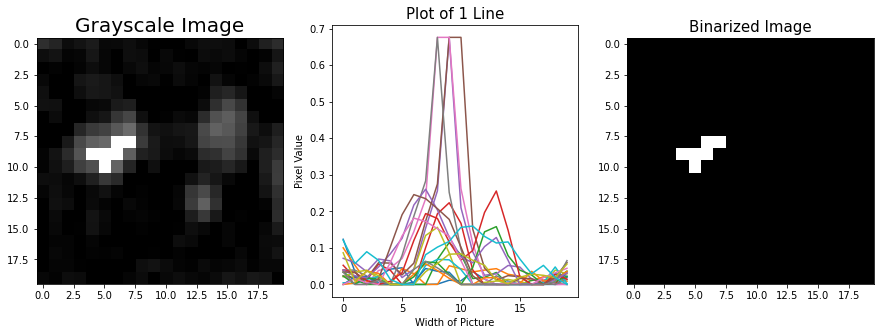

In [298]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sample_b = sample_g > 0.3
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(sample_g,cmap='gray')
ax[1].plot(sample_g)
ax[1].set_ylabel('Pixel Value')
ax[1].set_xlabel('Width of Picture')
ax[1].set_title('Plot of 1 Line',fontsize=15)
ax[2].set_title('Binarized Image',fontsize=15)
ax[2].imshow(sample_b,cmap='gray')